In [1]:
from vade.model import VADE
from vade.data import DATASETS
from torch.utils.data import DataLoader
from vade.device import DEVICE
from sklearn.cluster import KMeans
import torch
import numpy as np
from sklearn.metrics import (
    rand_score,
    silhouette_score,
    calinski_harabasz_score,
)
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_name = "MNIST"

In [13]:
model = (
    VADE.load_from_checkpoint(
        "results/MNIST/VADE/BasicTraining/lightning_logs/version_15/checkpoints/best_model-epoch=20-val_loss=144.9641-train_loss=144.0144.ckpt"
    )
    .to(DEVICE)
    .double()
)

In [14]:
dataset = DATASETS[dataset_name]["test"]
dataloader = DataLoader(dataset, 32)

### Prediction generation

In [15]:
predictions = []
latent_representations = []
true_labels = []
for X, y in dataloader:
    X = X.to(DEVICE)
    with torch.no_grad():
        predictions.append(model(X))
        latent_representations.append(model.mu_encoder(model.encode(X)))
    true_labels.append(y)
predictions = torch.concat(predictions).cpu().numpy()
latent_representations = torch.concat(latent_representations).cpu().numpy()
true_labels = torch.concat(true_labels).cpu().numpy()
n_clusters = np.unique(true_labels).shape[0]

### Clustering of latent space vs true classes

In [16]:
clustering = KMeans(n_clusters=n_clusters, random_state=123)
clusters = clustering.fit_predict(latent_representations)
print(f"{rand_score(true_labels, clusters)}")

0.9276559655965596


### Clustering metrics of latent space

In [17]:
print(f"{silhouette_score(latent_representations, clusters).item()=}")
print(f"{calinski_harabasz_score(latent_representations, clusters).item()=}")

silhouette_score(latent_representations, clusters).item()=0.21246667070111588
calinski_harabasz_score(latent_representations, clusters).item()=2171.3777059660993


### Clusters visualizations
* (with true labels as colors)

In [18]:
stratified_sample_X = []
stratified_sample_true_labels = []
for i in range(n_clusters):
    stratified_sample_X.append(latent_representations[true_labels == i][:100])
    stratified_sample_true_labels.append(true_labels[true_labels == i][:100])
stratified_sample_X = np.concat(stratified_sample_X)
stratified_sample_true_labels = np.concat(stratified_sample_true_labels)

In [22]:
stratified_sample_X = np.vstack([stratified_sample_X, model.mu.detach().cpu().numpy(), clustering.cluster_centers_])
stratified_sample_true_labels = np.concat([stratified_sample_true_labels, np.ones(10)*-1, np.ones(10)*-2])

In [23]:
reduced_data = TSNE(2).fit_transform(stratified_sample_X)

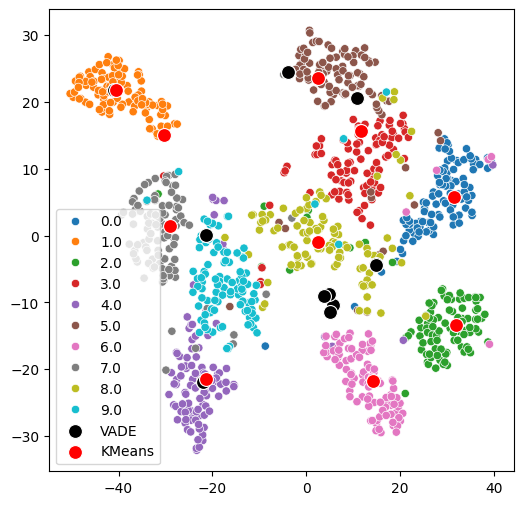

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels > -1],
    y=reduced_data[:, 1][stratified_sample_true_labels > -1],
    hue=stratified_sample_true_labels[stratified_sample_true_labels > -1].tolist(),
    palette="tab10",
)
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels == -1],
    y=reduced_data[:, 1][stratified_sample_true_labels == -1],
    color='black',
    s=100,
    label='VADE'
)
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels == -2],
    y=reduced_data[:, 1][stratified_sample_true_labels == -2],
    color='red',
    s=100,
    label='KMeans'
)
plt.legend()

### Observation from each cluster 
* (for img visualize, for HAR calculate distance from points of this cluster, compare to distance from other cluster, compare to distances of real observations)

In [27]:
assert isinstance(model, VADE), "This result supports only VADE"

In [28]:
diff = model.mu.unsqueeze(1) - model.mu.unsqueeze(0)

pairwise_distances = torch.norm(diff, dim=-1)

num_tensors = model.mu.size(0)
average_distance = pairwise_distances.sum() / (
    num_tensors * (num_tensors - 1)
)
average_distance

tensor(3.0973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [29]:
model.logvar.exp().mean(dim=1)

tensor([0.7390, 0.8762, 0.8741, 0.8767, 0.5814, 0.9744, 0.8175, 0.9296, 0.2926,
        0.7681], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

In [30]:
from torch import Tensor

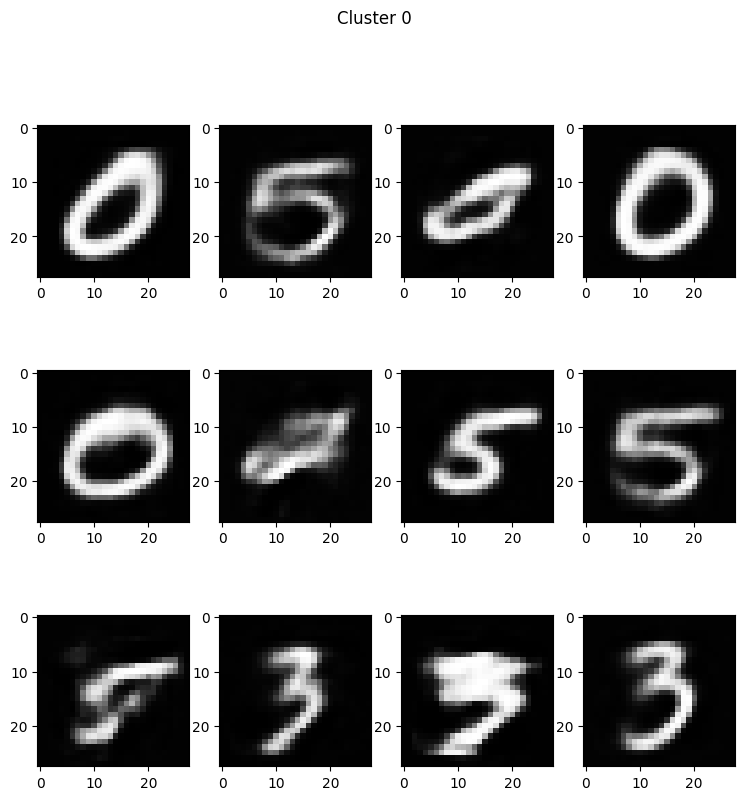

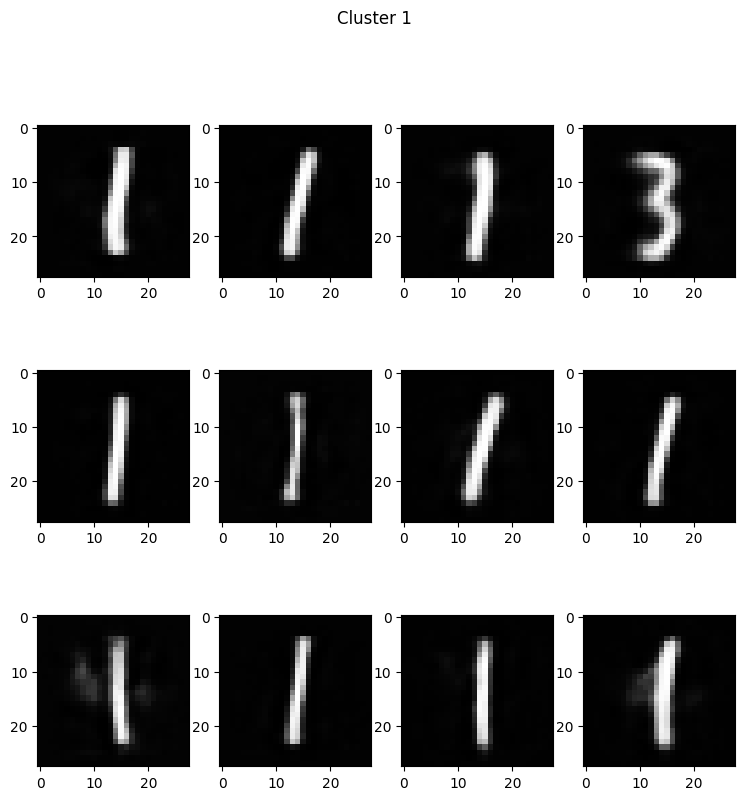

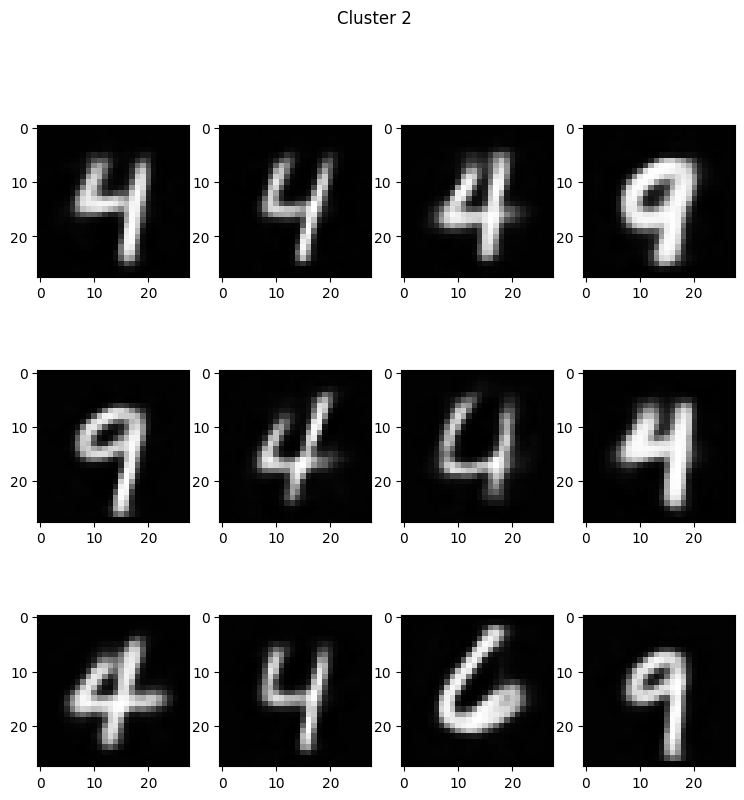

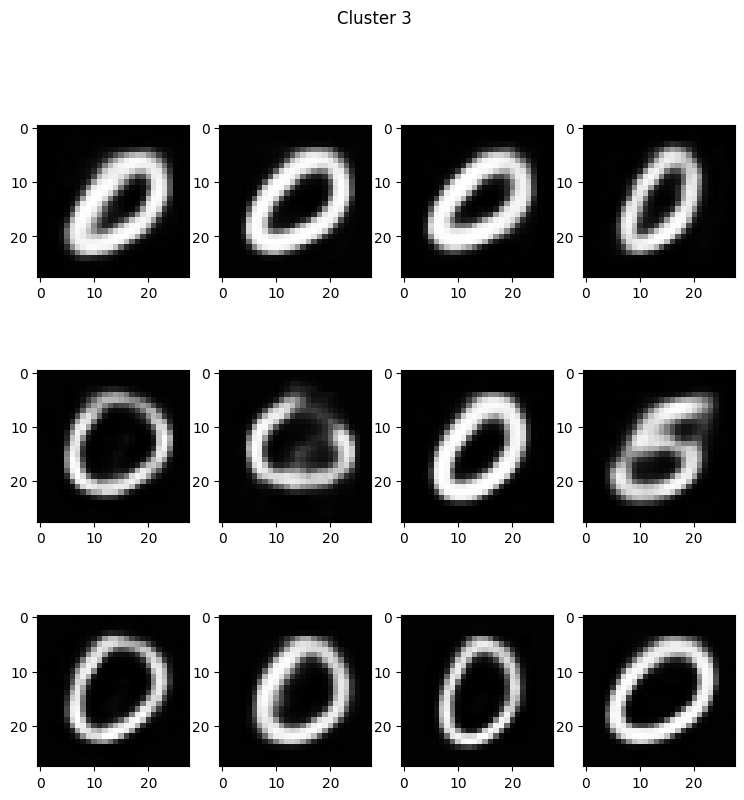

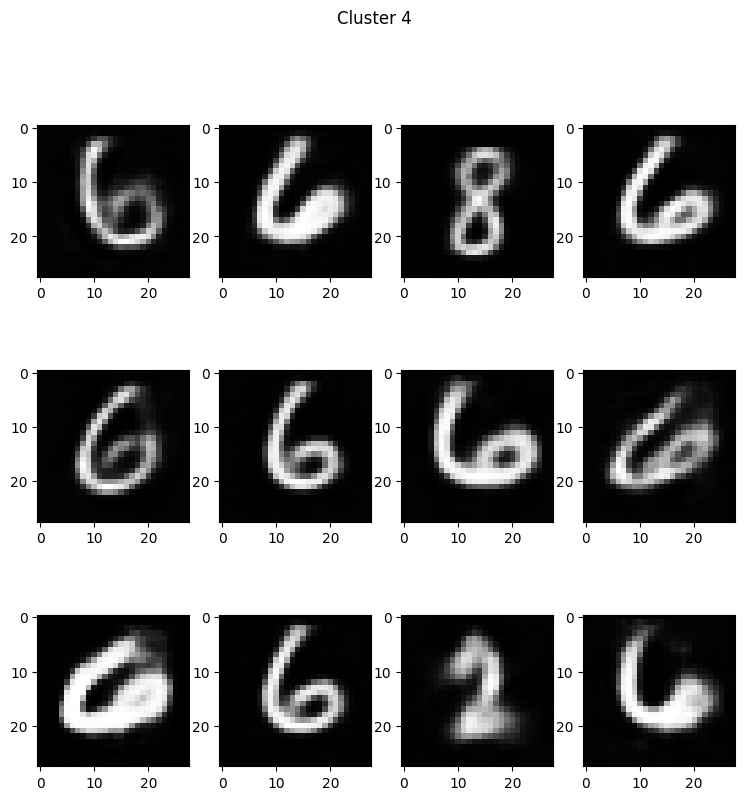

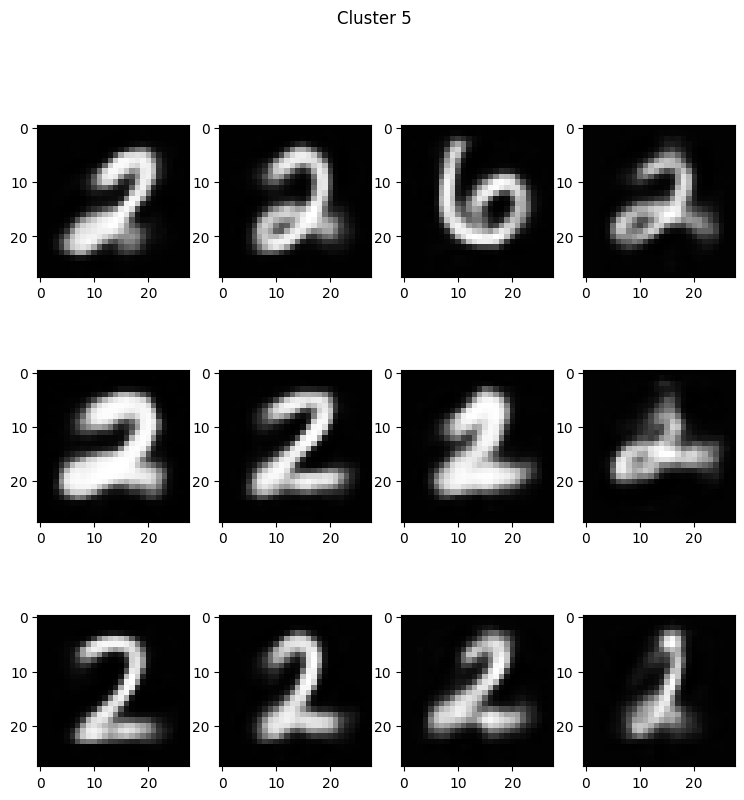

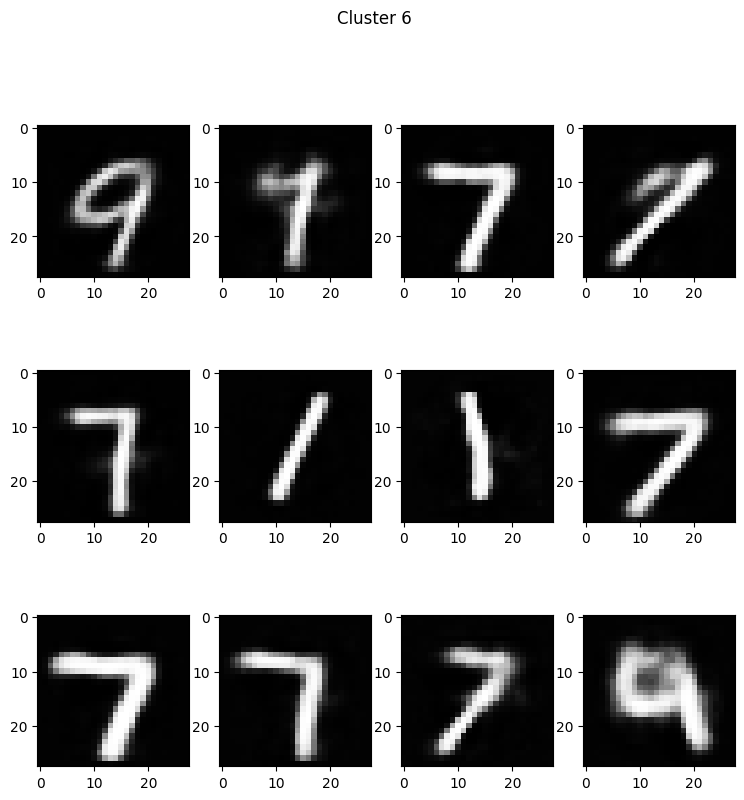

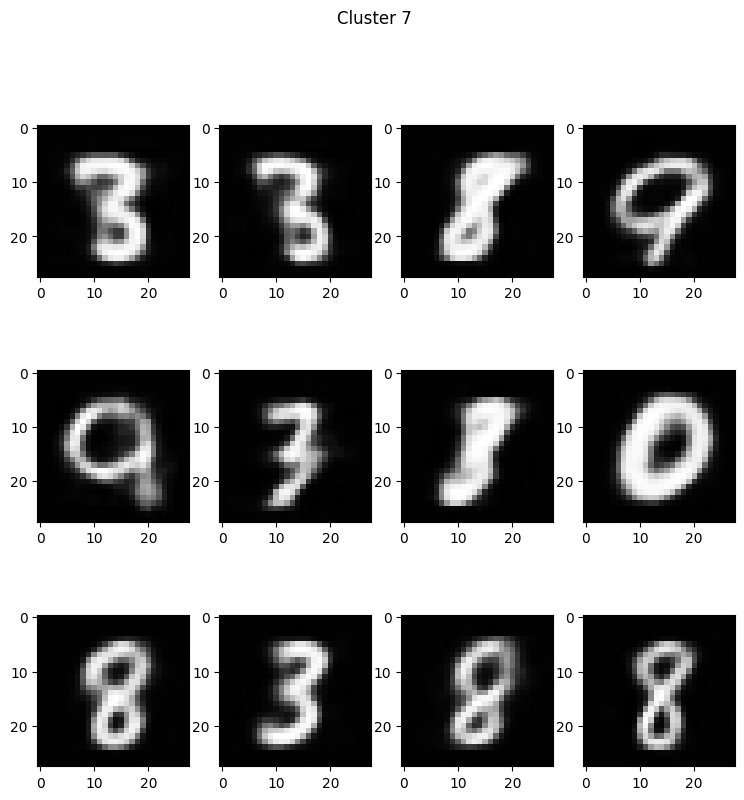

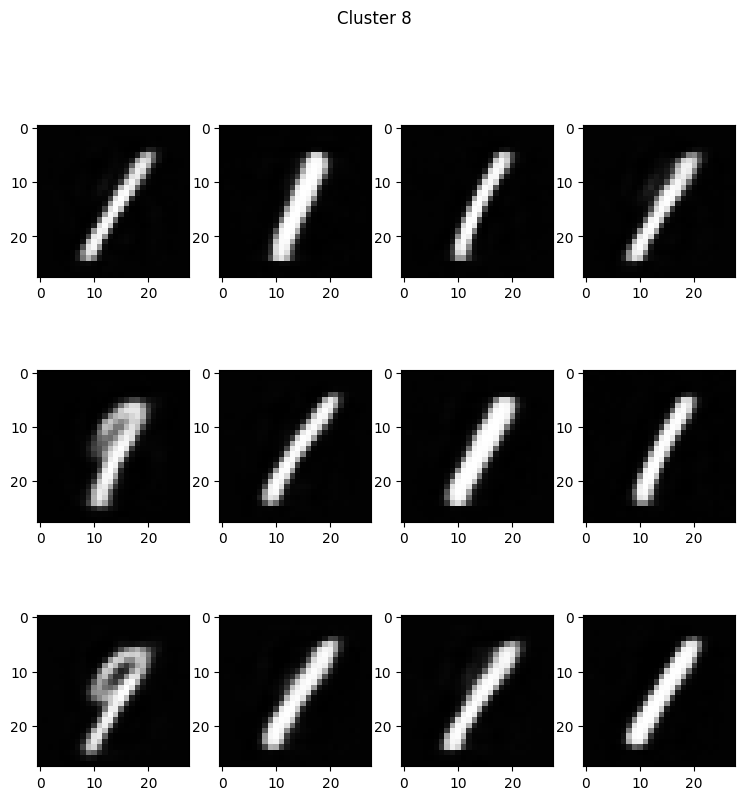

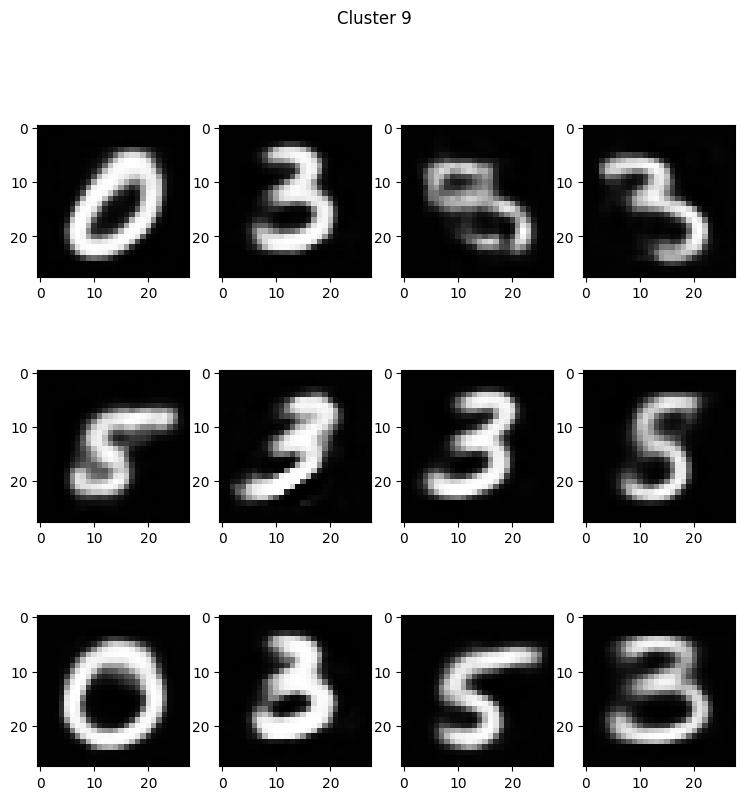

In [31]:
for class_ in range(10):
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9, 9))
    for idx in range(12):
        r = torch.randn(size=(model.layers_sizes[-1],)).cuda()
        z = r * torch.exp(model.logvar[class_]) + Tensor(clustering.cluster_centers_[class_]).cuda()
        # + model.mu[class_]
        mu, logvar = model.mu_encoder(z), model.logvar_encoder(z)
        latent = model.reparametrize(mu, logvar)
        output = model.decode(z)
        output_img = output.reshape(28, 28).cpu().detach().numpy()
        ax_to_plot = ax[idx // 4][idx % 4]
        ax_to_plot.imshow(output_img, cmap="gray")
        # ax_to_plot.set_title(f"Class: {class_}")
    fig.suptitle(f'Cluster {class_}')